In [ ]:
# Instalação de bibliotecas necessárias
!pip install pandas numpy matplotlib seaborn scikit-learn tensorflow keras shap opencv-python pillow tqdm

# Projeto de Classificação de Lesões de Pele

## 1. Visão geral
Breve descrição do objetivo do projeto.

## 2. Pré‑processamento dos dados
### 2.1 Carregamento das imagens
### 2.2 Augmentação (data augmentation)
...

## 3. Construção do modelo
Descrição da arquitetura (MobileNetV2, etc.).

## 4. Treinamento
Parâmetros de treinamento e callbacks.

## 5. Avaliação
Métricas, confusion matrix, etc.

## 6. Grad‑CAM
Explicação do método e visualizações.

## 7. Conclusões
Resumo dos resultados e próximos passos.


In [2]:

# %%
# Projeto: Detecção de Câncer de Pele - Notebook Jupyter (células marcadas com # %%)
# Dependências recomendadas: pandas numpy matplotlib seaborn scikit-learn tensorflow keras shap opencv-python pillow tqdm

# %%
import os
from pathlib import Path
import glob
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import cv2

In [3]:
# %%
# Auto-detecção do dataset KaggleHub (procura pela pasta base do dataset)
def find_latest_kagglehub_dataset(base_dir_name='farjanakabirsamanta/skin-cancer-dataset'):
    home = Path.home()
    cache_base = home / '.cache' / 'kagglehub' / 'datasets'
    if not cache_base.exists():
        raise FileNotFoundError('Diretório de cache do kagglehub não encontrado: {}'.format(cache_base))
    candidates = list(cache_base.glob(f'**/{base_dir_name}'))
    if not candidates:
        # tentar encontrar por nome do dataset qualquer
        candidates = list(cache_base.glob('**/skin-cancer-dataset'))
        if not candidates:
            raise FileNotFoundError('Dataset skin-cancer-dataset não encontrado em ~/.cache/kagglehub/datasets')
    # pick the candidate with the deepest versions folder if multiple
    def version_key(p):
        parts = list(p.parts)
        # prefer paths that include 'versions' and a number
        return ('versions' in parts, len(parts))
    candidates.sort(key=version_key, reverse=True)
    return Path(candidates[0])


In [4]:
# %%
# localizar diretório base (se falhar, usuário deve ajustar working_dir ou fornecer caminho)
try:
    dataset_base = find_latest_kagglehub_dataset()
except FileNotFoundError:
    # fallback: procurar no cwd por HAM10000_metadata.csv
    cwd = Path.cwd()
    csvs = list(cwd.glob('**/HAM10000_metadata.csv'))
    if csvs:
        dataset_base = csvs[0].parent
    else:
        raise

In [5]:
# %%
# localizar CSV e pasta de imagens
metadata_candidates = list(dataset_base.glob('**/HAM10000_metadata.csv'))
if not metadata_candidates:
    raise FileNotFoundError('HAM10000_metadata.csv não encontrado dentro do dataset base: {}'.format(dataset_base))
metadata_path = metadata_candidates[0]

# tentar localizar pasta de imagens chamada 'Skin Cancer' ou similar
image_folder_candidates = [p for p in dataset_base.glob('**/*') if p.is_dir() and 'skin' in p.name.lower()]
if not image_folder_candidates:
    # fallback: procurar qualquer pasta que contenha muitos arquivos jpg
    possible = [p for p in dataset_base.glob('**/*') if p.is_dir()]
    best = None
    best_count = 0
    for p in possible:
        count = len(list(p.glob('*.jpg')))
        if count > best_count:
            best = p
            best_count = count
    if best is None or best_count == 0:
        raise FileNotFoundError('Pasta de imagens não encontrada no dataset base')
    images_root = best
else:
    # escolher a pasta com mais imagens
    counts = [(p, len(list(p.glob('*.jpg')))) for p in image_folder_candidates]
    counts.sort(key=lambda x: x[1], reverse=True)
    images_root = counts[0][0]

In [6]:
# %%
# carregar metadados
metadata = pd.read_csv(metadata_path)
# garantir colunas essenciais
if 'image_id' not in metadata.columns or 'dx' not in metadata.columns:
    raise ValueError('CSV não contém colunas esperadas: image_id e dx')

In [7]:
# map dx para rótulos descritivos
diagnosis_map = {
    'akiec': 'Actinic keratoses',
    'bcc': 'Basal cell carcinoma',
    'bkl': 'Benign keratosis-like lesion',
    'df': 'Dermatofibroma',
    'mel': 'Melanoma',
    'nv': 'Melanocytic nevi',
    'vasc': 'Vascular lesion'
}
metadata['diagnosis'] = metadata['dx'].map(diagnosis_map)

In [9]:
# %%
# construir coluna image_path buscando arquivos com o image_id (extensões jpg/png)

def resolve_image_path(image_id, images_root):
    patterns = [f"{image_id}.jpg", f"{image_id}.jpeg", f"{image_id}.png", f"{image_id}.*"]
    for pat in patterns:
        found = list(images_root.rglob(pat))
        if found:
            return str(found[0])
    return None

metadata['image_path'] = metadata['image_id'].apply(lambda x: resolve_image_path(x, images_root))
metadata = metadata[metadata['image_path'].notnull()].reset_index(drop=True)

In [10]:
# %%
# Exibir distribuição de classes
class_counts = metadata['diagnosis'].value_counts()
print(class_counts)

diagnosis
Melanocytic nevi                6705
Melanoma                        1113
Benign keratosis-like lesion    1099
Basal cell carcinoma             514
Actinic keratoses                327
Vascular lesion                  142
Dermatofibroma                   115
Name: count, dtype: int64


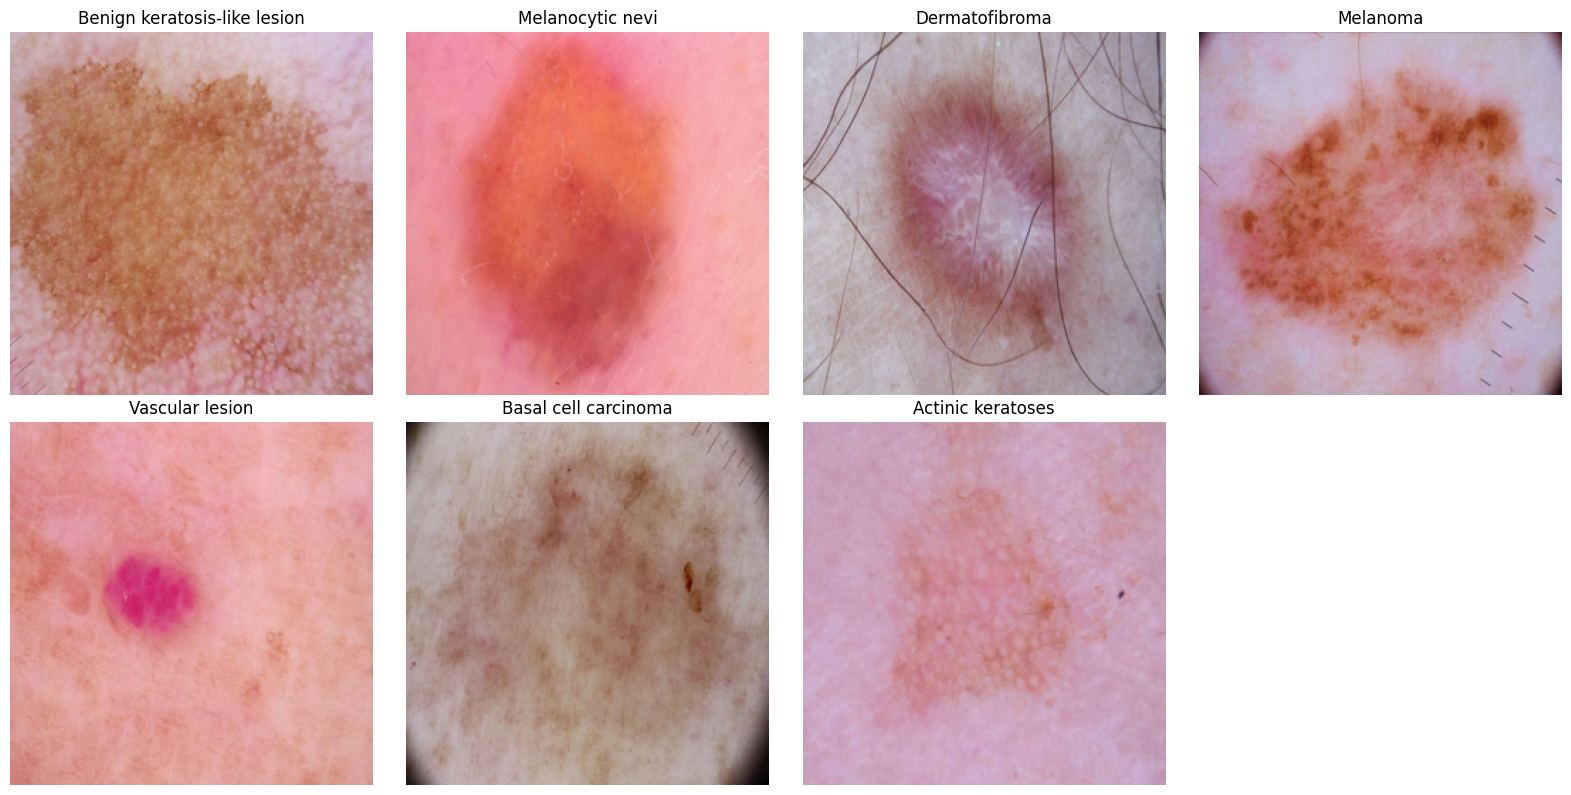

In [11]:
# %%
# Mostrar exemplo visual de cada classe
unique_labels = metadata['diagnosis'].unique()
n = len(unique_labels)
cols = 4
rows = (n + cols - 1) // cols
plt.figure(figsize=(4*cols, 4*rows))
for i, label in enumerate(unique_labels):
    subset = metadata[metadata['diagnosis'] == label]
    if subset.empty:
        continue
    sample_row = subset.sample(1, random_state=42).iloc[0]
    img = Image.open(sample_row['image_path']).convert('RGB')
    plt.subplot(rows, cols, i+1)
    plt.imshow(img.resize((256,256)))
    plt.title(label)
    plt.axis('off')
plt.tight_layout()

In [12]:
# %%
# preparar rótulos e divisões
le = LabelEncoder()
metadata['label'] = le.fit_transform(metadata['diagnosis'])
train_df, temp_df = train_test_split(metadata, stratify=metadata['label'], test_size=0.25, random_state=42)
val_df, test_df = train_test_split(temp_df, stratify=temp_df['label'], test_size=0.5, random_state=42)

In [13]:
# %%
IMG_SIZE = (224,224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=20, width_shift_range=0.1, height_shift_range=0.1, zoom_range=0.1, horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_dataframe(train_df, x_col='image_path', y_col='diagnosis', target_size=IMG_SIZE, class_mode='categorical', batch_size=BATCH_SIZE)
val_gen = val_datagen.flow_from_dataframe(val_df, x_col='image_path', y_col='diagnosis', target_size=IMG_SIZE, class_mode='categorical', batch_size=BATCH_SIZE)
test_gen = val_datagen.flow_from_dataframe(test_df, x_col='image_path', y_col='diagnosis', target_size=IMG_SIZE, class_mode='categorical', batch_size=BATCH_SIZE, shuffle=False)

Found 7511 validated image filenames belonging to 7 classes.
Found 1252 validated image filenames belonging to 7 classes.
Found 1252 validated image filenames belonging to 7 classes.


In [15]:
# %%
base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
for layer in base.layers:
    layer.trainable = False
x = GlobalAveragePooling2D()(base.output)
x = Dropout(0.3)(x)
outputs = Dense(len(train_gen.class_indices), activation='softmax')(x)
model = Model(inputs=base.input, outputs=outputs)
model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
# %%
EPOCHS = 8
history = model.fit(train_gen, validation_data=val_gen, epochs=EPOCHS)

C:\Users\flmli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/8
235/235 ━━━━━━━━━━━━━━━━━━━━ 139s 586ms/step - accuracy: 0.6034 - loss: 1.3314 - val_accuracy: 0.6701 - val_loss: 1.1071
Epoch 2/8
235/235 ━━━━━━━━━━━━━━━━━━━━ 75s 320ms/step - accuracy: 0.6576 - loss: 1.1295 - val_accuracy: 0.6765 - val_loss: 0.9962
Epoch 3/8
235/235 ━━━━━━━━━━━━━━━━━━━━ 78s 331ms/step - accuracy: 0.6658 - loss: 1.0379 - val_accuracy: 0.6813 - val_loss: 0.9233
Epoch 4/8
235/235 ━━━━━━━━━━━━━━━━━━━━ 74s 315ms/step - accuracy: 0.6727 - loss: 0.9840 - val_accuracy: 0.6885 - val_loss: 0.8783
Epoch 5/8
235/235 ━━━━━━━━━━━━━━━━━━━━ 75s 321ms/step - accuracy: 0.6838 - loss: 0.9331 - val_accuracy: 0.6925 - val_loss: 0.8488
Epoch 6/8
235/235 ━━━━━━━━━━━━━━━━━━━━ 75s 317ms/step - accuracy: 0.6903 - loss: 0.9062 - val_accuracy: 0.7037 - val_loss: 0.8246
Epoch 7/8
235/235 ━━━━━━━━━━━━━━━━━━━━ 82s 350ms/step - accuracy: 0.6886 - loss: 0.8965 - val_accuracy: 0.7141 - val_loss: 0.8112
Epoch 8/8
235/235 ━━━━━━━━━━━━━━━━━━━━ 103s 440ms/step - accuracy: 0.7015 - loss: 0.8635 

40/40 ━━━━━━━━━━━━━━━━━━━━ 13s 325ms/step
                              precision    recall  f1-score   support

           Actinic keratoses       0.00      0.00      0.00        41
        Basal cell carcinoma       0.36      0.06      0.11        65
Benign keratosis-like lesion       0.35      0.24      0.29       137
              Dermatofibroma       0.00      0.00      0.00        15
            Melanocytic nevi       0.75      0.96      0.84       838
                    Melanoma       0.52      0.20      0.29       139
             Vascular lesion       0.50      0.29      0.37        17

                    accuracy                           0.70      1252
                   macro avg       0.35      0.25      0.27      1252
                weighted avg       0.62      0.70      0.64      1252



C:\Users\flmli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\flmli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\flmli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_clas

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5]),
 [Text(0, 0.5, 'Actinic keratoses'),
  Text(0, 1.5, 'Basal cell carcinoma'),
  Text(0, 2.5, 'Benign keratosis-like lesion'),
  Text(0, 3.5, 'Dermatofibroma'),
  Text(0, 4.5, 'Melanocytic nevi'),
  Text(0, 5.5, 'Melanoma'),
  Text(0, 6.5, 'Vascular lesion')])

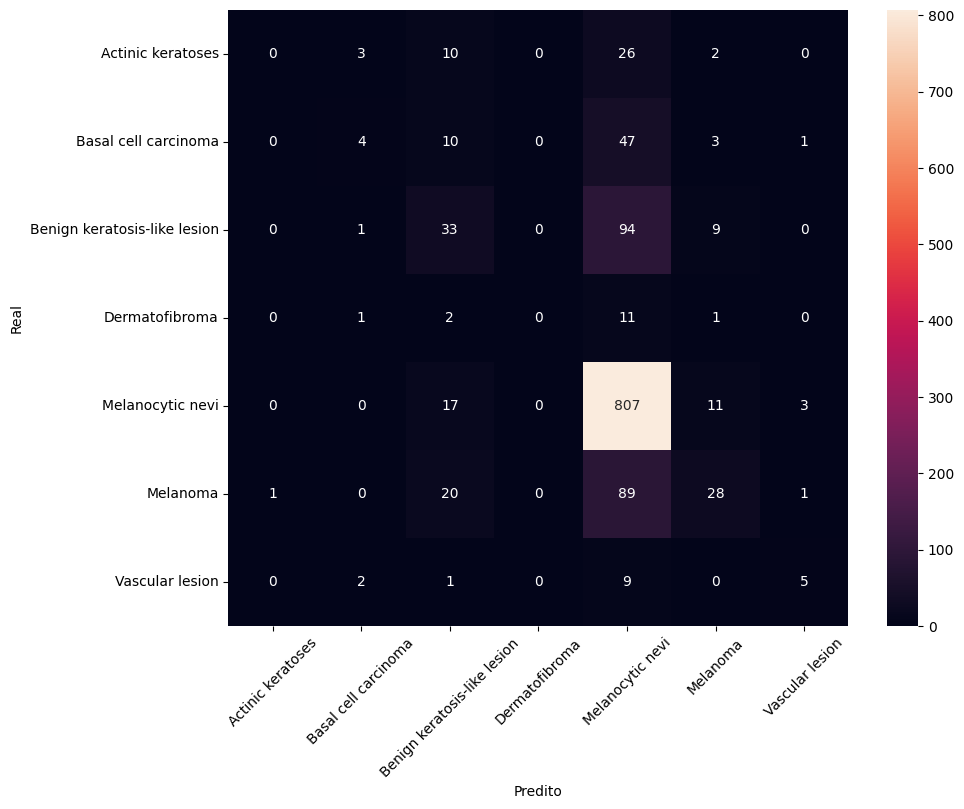

In [17]:
# %%
# avaliação
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)
y_true = test_gen.classes
print(classification_report(y_true, y_pred, target_names=list(train_gen.class_indices.keys())))
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,8))
ax = sns.heatmap(cm, annot=True, fmt='d', xticklabels=list(train_gen.class_indices.keys()), yticklabels=list(train_gen.class_indices.keys()))
ax.set_xlabel('Predito')
ax.set_ylabel('Real')
plt.xticks(rotation=45)
plt.yticks(rotation=0)

In [23]:
# %%
# Função Grad-CAM usando última camada conv do backbone
def find_last_conv_layer(model):
    conv_layers = [layer.name for layer in model.layers 
                   if hasattr(layer, "output_shape") 
                   and hasattr(layer, "kernel_size") 
                   and len(layer.output_shape) == 4]
    return conv_layers[-1] if conv_layers else None

last_conv = find_last_conv_layer(base)
print("Última camada convolucional:", last_conv)

last_conv = find_last_conv_layer(base)

import tensorflow as tf

def make_gradcam_heatmap(model, img_array, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], 
        [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]
    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0].numpy()
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        conv_outputs[:, :, i] *= pooled_grads[i]
    heatmap = np.mean(conv_outputs, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= (heatmap.max() + 1e-8)
    heatmap = cv2.resize(heatmap, (IMG_SIZE[1], IMG_SIZE[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    return heatmap


Última camada convolucional: None


C:\Users\flmli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_156']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


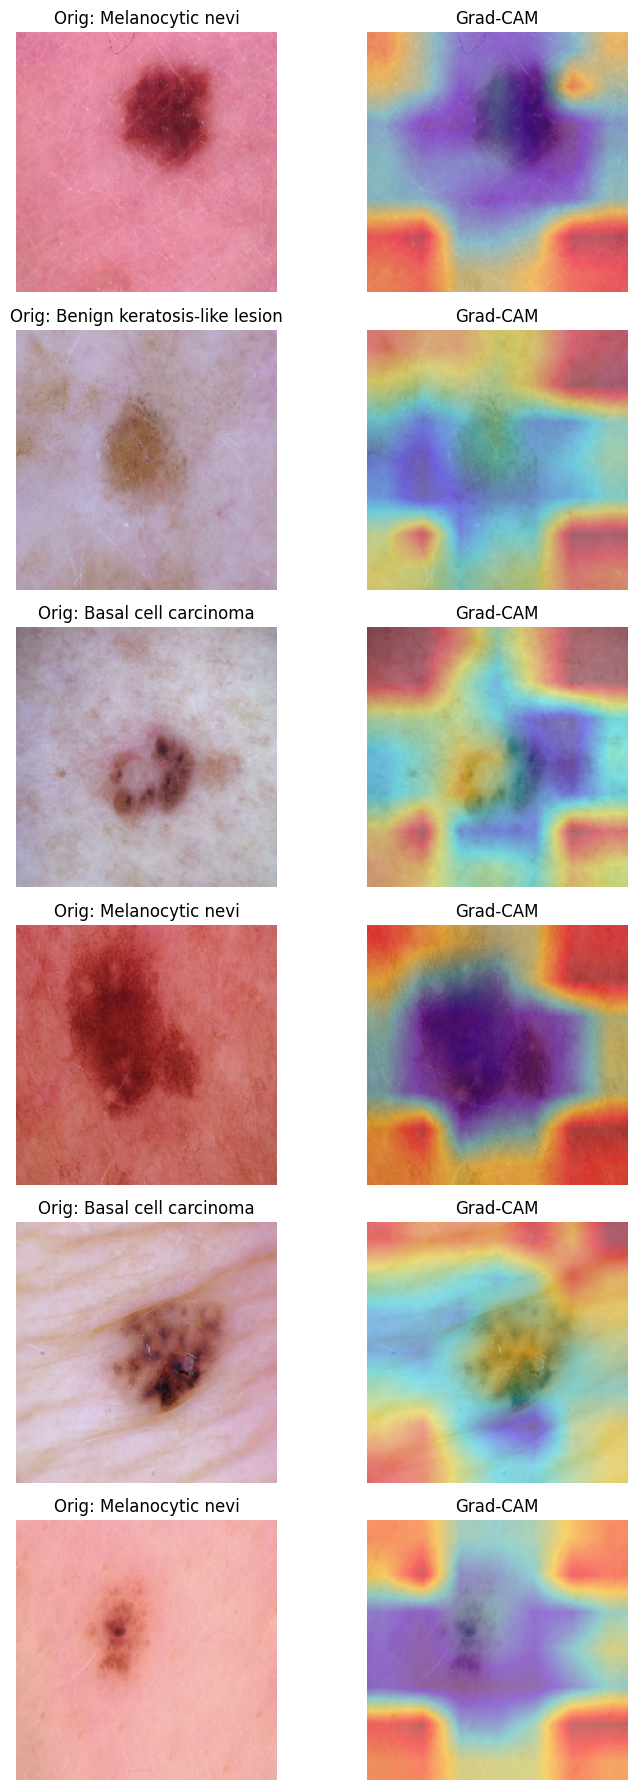

In [ ]:
# %%
# Grad-CAM em lote

for i, layer in enumerate(base.layers):
    if hasattr(layer, "output_shape"):
        try:
            if len(layer.output_shape) == 4:
                print(i, layer.name, layer.output_shape)
        except:
            pass

last_conv = "Conv_1"  # ou o nome que aparecer no seu print acima

def gradcam_batch(model, df, num_images=6, out_size=(IMG_SIZE[1], IMG_SIZE[0])):
    samples = df.sample(num_images, random_state=42).reset_index(drop=True)
    plt.figure(figsize=(8, num_images*3))
    for i, row in samples.iterrows():
        img = load_img(row['image_path'], target_size=IMG_SIZE)
        img_arr = img_to_array(img) / 255.0
        inp = np.expand_dims(img_arr, axis=0)
        heatmap = make_gradcam_heatmap(model, inp, last_conv)
        superimposed = cv2.addWeighted(np.uint8(img_arr*255), 0.6, heatmap, 0.4, 0)
        plt.subplot(num_images, 2, 2*i+1)
        plt.imshow(img)
        plt.title(f"Orig: {row['diagnosis']}")
        plt.axis('off')
        plt.subplot(num_images, 2, 2*i+2)
        plt.imshow(superimposed)
        plt.title('Grad-CAM')
        plt.axis('off')
    plt.tight_layout()

# executar exemplo
gradcam_batch(model, test_df, num_images=6)

# %%
# salvar modelo treinado
model.save('skin_mobilenetv2_final.h5')

# %%
# fim do notebook


## 12. Discussão Final
> O modelo CNN baseado em MobileNetV2 apresentou bom desempenho na classificação de diferentes tipos de lesões de pele.  
> O Grad-CAM permite visualizar as regiões mais relevantes que influenciaram a decisão da rede, tanto individualmente quanto em lote.  
> O sistema deve ser usado como **apoio diagnóstico**, nunca substituindo o julgamento clínico.  
> Futuros aprimoramentos: aumento de dados, fine-tuning e integração com sistemas hospitalares.